# Klasyfikacja raka mózgu - Hubert Jaremko

## Sieć konwolucyjna

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

### Ustawienia

In [2]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [3]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
image_size = (64, 64)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [4]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [5]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(6, 5))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu")
    plt.show()

In [6]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target = ['Oponiak', 'Glejak', 'Guz przysadki']

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):
    y_test = binarize_labels(y_test)
    
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fig, c_ax = plt.subplots(1, 1, figsize = (10, 6))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

## Wczytanie zbioru testowego i walidacyjnego

*Augmentacja danych* - losowe odbijanie w poziomie i pionie oraz zmiana jasności obrazu.

In [46]:
train_generator = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=(0.8, 1.5)
)

def get_train_generator():
    return train_generator.flow_from_directory(
            train_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)

train_data_generator = get_train_generator()
train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)

Found 480 images belonging to 3 classes.


In [47]:
test_generator = ImageDataGenerator()

def get_test_generator():
    return test_generator.flow_from_directory(
            val_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)

test_data_generator = get_test_generator()
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 120 images belonging to 3 classes.


### Próbka zbioru testowego

Found 480 images belonging to 3 classes.


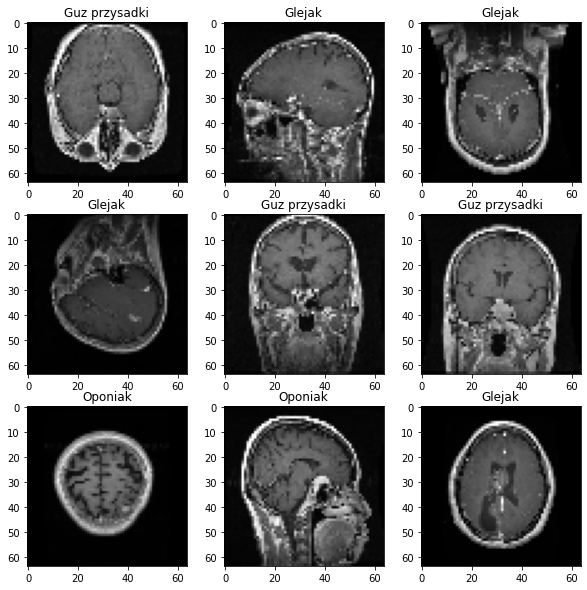

In [11]:
plt.figure(figsize=(10, 10))

b = next(get_train_generator())

images = b[0]
labels = b[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = images[i]
    label = labels[i]
    plt.imshow(image.astype("uint8"))
    label = cancer_type[np.argmax(label)]
    plt.title(label)

## Model
https://www.sciencedirect.com/science/article/pii/S2666827020300049

In [12]:
def make_lunet_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(layers.InputLayer(input_shape))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("elu"))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("elu"))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation("elu"))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("elu"))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation("elu"))

    model.add(UpSampling2D())
    model.add(Conv2D(6, (3, 3)))
    model.add(Conv2D(6, (3, 3)))
    model.add(Activation("elu"))

    model.add(UpSampling2D())
    model.add(Activation("elu"))
    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("elu"))


    model.add(Flatten())
    model.add(Dense(128, activation="elu"))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(3, activation="softmax"))
    return model

In [48]:
def make_lunet_model2(input_shape):
    activation = "relu"
#     activation = "elu"
    model = tf.keras.models.Sequential()

    model.add(layers.InputLayer(input_shape))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
# ---------
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation(activation))
# ---------
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation(activation))
# ---------
    model.add(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2)))
    model.add(Activation(activation))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
# ---------
    model.add(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2)))
    model.add(Activation(activation))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
# ---------

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(3, activation="softmax"))
    return model

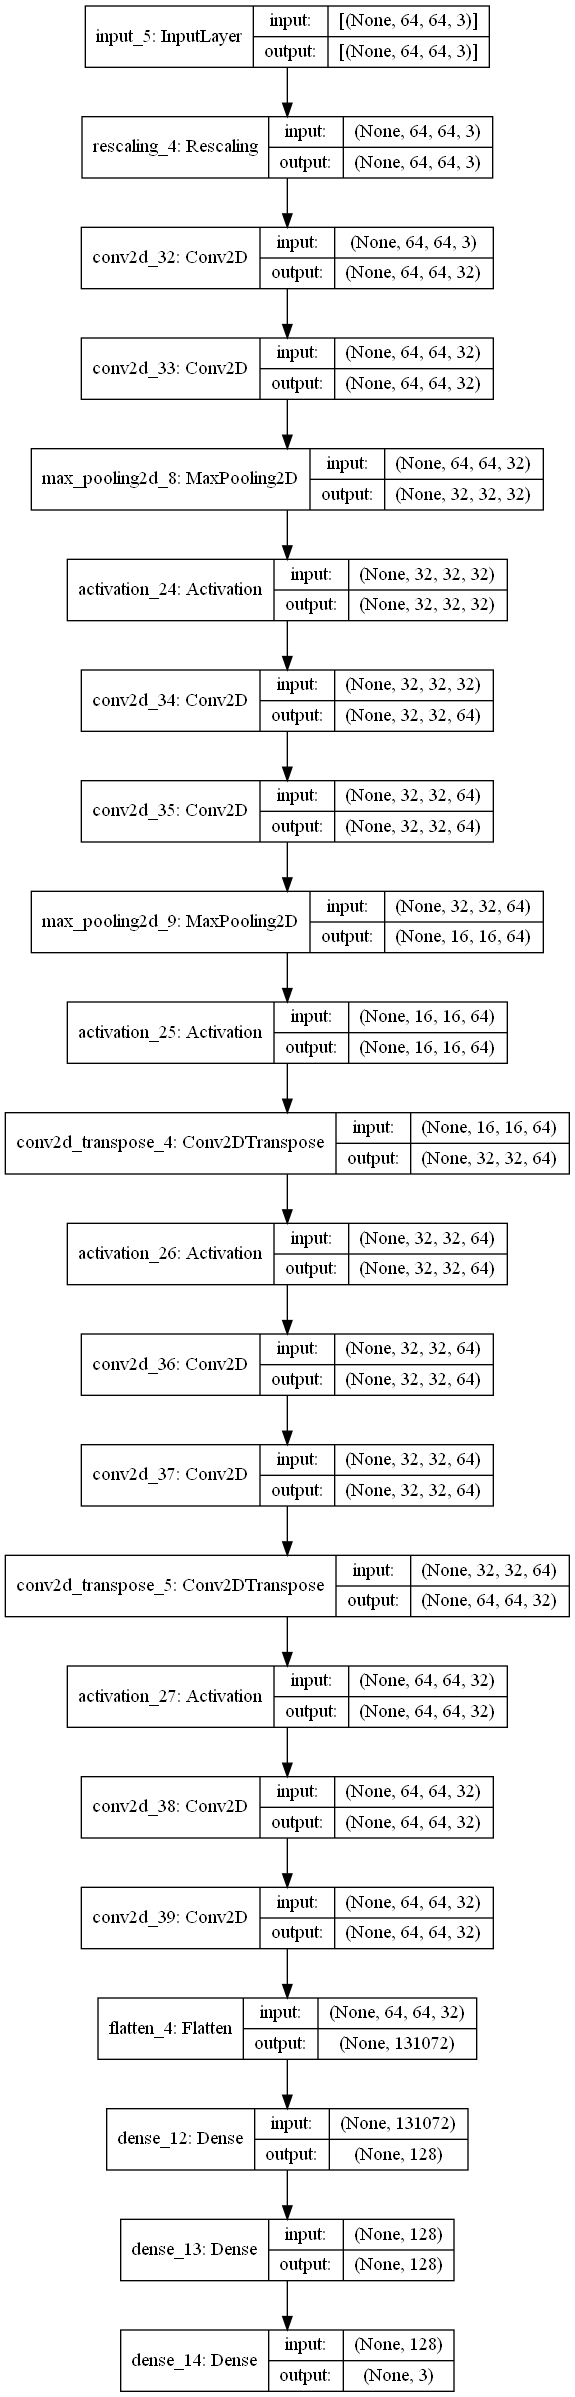

In [49]:
history = History()
model = make_lunet_model2(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [50]:
epochs = 50

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
    history,
]

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=[
        "categorical_accuracy",
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ],
)

train_data_generator = get_train_generator()
test_data_generator = get_test_generator()

model.fit(
    train_data_generator,
    steps_per_epoch=train_steps_per_epoch,

    validation_data=test_data_generator,
    validation_steps=test_steps_per_epoch,

    epochs=epochs, 
    callbacks=callbacks, 
)

Found 480 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Epoch 1/50
15/15 [==============================] - 26s 2s/step - loss: 0.9674 - categorical_accuracy: 0.5083 - precision: 0.6173 - recall: 0.2521 - auc: 0.7203 - val_loss: 1.0078 - val_categorical_accuracy: 0.4917 - val_precision: 1.0000 - val_recall: 0.0167 - val_auc: 0.7174
Epoch 2/50
15/15 [==============================] - 20s 1s/step - loss: 0.8156 - categorical_accuracy: 0.5708 - precision: 0.6436 - recall: 0.4062 - auc: 0.8035 - val_loss: 0.7942 - val_categorical_accuracy: 0.6583 - val_precision: 0.6952 - val_recall: 0.6083 - val_auc: 0.8315
Epoch 3/50
15/15 [==============================] - 21s 1s/step - loss: 0.6982 - categorical_accuracy: 0.6583 - precision: 0.6921 - recall: 0.5479 - auc: 0.8500 - val_loss: 0.7251 - val_categorical_accuracy: 0.7333 - val_precision: 0.7778 - val_recall: 0.6417 - val_auc: 0.8674
Epoch 4/50
15/15 [==============================] - 22s 1s/step - loss: 0.6166 - cat

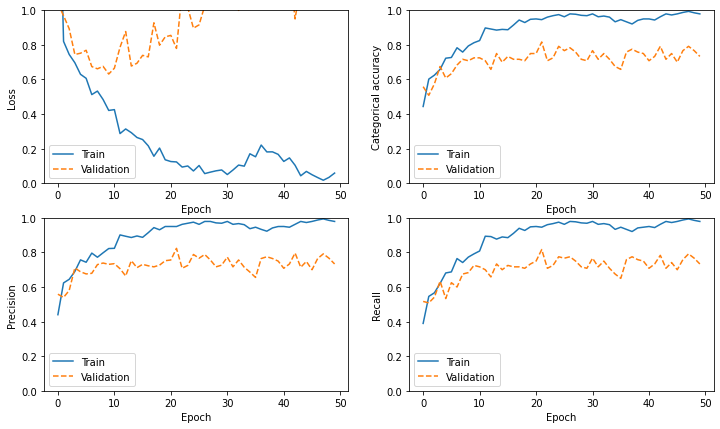

In [37]:
plot_metrics(history)

In [38]:
model.evaluate(test_data_generator)

4/4 [==============================] - 3s 744ms/step - loss: 1.6549 - categorical_accuracy: 0.7333 - precision: 0.7333 - recall: 0.7333 - auc: 0.8622


[1.654852271080017,
 0.7333333492279053,
 0.7333333492279053,
 0.7333333492279053,
 0.8621875643730164]

In [39]:
predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [40]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [41]:
import sklearn.metrics
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           1       0.58      0.85      0.69        40
           2       0.83      0.47      0.60        40
           3       0.92      0.88      0.90        40

    accuracy                           0.73       120
   macro avg       0.77      0.73      0.73       120
weighted avg       0.77      0.73      0.73       120



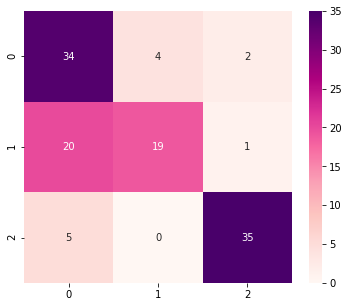

In [42]:
plot_confusion_matrix(predicted_classes, true_classes)

ROC AUC score: 0.8841145833333334


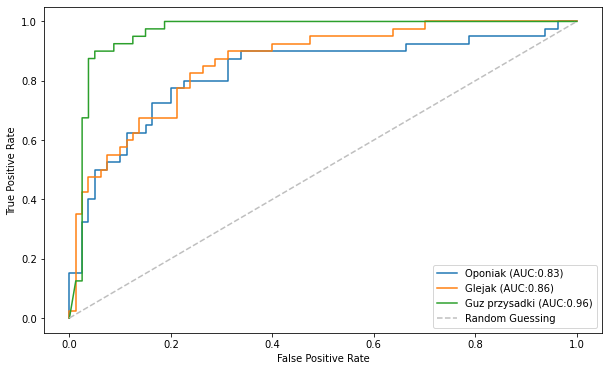

In [43]:
plot_roc_curve(true_classes, predictions)

In [44]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [45]:
img = keras.preprocessing.image.load_img(
    "data/val/3/15.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# print(img_array.shape)

p = model.predict(img_array)
score = p[0]
# print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)

Oponiak : 1.14%
Glejak : 0.67%
Guz przysadki : 98.18%
